##### Figure 10
# CONUS percentile threshold

In [1]:
%matplotlib inline
import h5py
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
from mpl_toolkits.basemap import Basemap

import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v2')
from BB_downloads.HRRR_S3 import *
from BB_wx_calcs.wind import wind_uv_to_spd
from BB_basemap.draw_maps import draw_CONUS_HRRR_map
from BB_MesoWest.MesoWest_STNinfo import get_MW_location_dict
from BB_MesoWest.MesoWest_timeseries import get_mesowest_ts
from BB_MesoWest.MesoWest_nearesttime import get_mesowest_nearesttime
from BB_MesoWest.MesoWest_percentiles import get_mesowest_percentiles
from BB_data.grid_manager import pluck_point_new
from BB_wx_calcs.wind import wind_uv_to_spd

In [2]:
from matplotlib.dates import DateFormatter
formatter = DateFormatter('%b')

import matplotlib as mpl 
two_column = 5.5
one_column = 3.2
twothird_column = 6.8
mpl.rcParams['figure.figsize'] = [6.5, 8.5]
mpl.rcParams['figure.titlesize'] = 12
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8
mpl.rcParams['axes.labelsize'] = 8
mpl.rcParams['axes.titlesize'] = 10
mpl.rcParams['lines.linewidth'] = 1.8
mpl.rcParams['grid.linewidth'] = .25
mpl.rcParams['figure.subplot.wspace'] = 0.03
mpl.rcParams['figure.subplot.hspace'] = 0.00
mpl.rcParams['legend.fontsize'] = 7
mpl.rcParams['legend.framealpha'] = .75
mpl.rcParams['legend.loc'] = 'best'
mpl.rcParams['savefig.bbox'] = 'tight'
    
mpl.rcParams['savefig.dpi'] = 600    # 600 for print

AMS Journal Figure size chart.  
_Note: Figsize parameter may differ from what is actually generated_

| One Colulmn | 2/3 Page   | Two Columns   | More than 2 columns  |
|---|---|---|---|
| 3.2   | 4.5  | 5.5  | 6.5  |


-----

# Percentile thresholds for given month and hour
Answers the question: At what percentile does the wind first exceed a threshold?  
- Darker colors = the wind threshold is more rare, becuase it is requires a 90th or 95th percentile to get that strong.  
- Lighter colors = the wind threshold is more common, becuase it only happens more than 10


## Draw Map Object

In [3]:
# Load Lat/Lon Grid
DIR = '/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/'
latlon_file = h5py.File(DIR+'OSG_HRRR_latlon.h5', 'r')
lat = latlon_file['latitude'].value
lon = latlon_file['longitude'].value

In [4]:
# Draw Map Object
from BB_basemap.draw_maps import draw_CONUS_HRRR_map
m = draw_CONUS_HRRR_map(res='f', area_thresh=1000000)

## Retrieve Wind Speed Percentiles that meet a threshold

In [5]:
def get_area(FILE, STAT):
    """
    Return the values from an area in the HDF5 file array
    """
    with h5py.File(FILE, 'r') as f:
        return f[STAT][:]

In [6]:
# Percentile Variable and Statistic of interest
var = 'UVGRD:10 m'
variable = var.replace(':', '_').replace(' ', '_')
DIR = '/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/%s/' % (variable)

# Specify Date: 
#  - Use a leapyear incase we request February 29th
#  - Use the 15th day of the month to capture the full month
leapyear = 2016
DATE = datetime(leapyear, 10, 15, 6)

# Requested File
FILE = DIR+'OSG_HRRR_%s_m%02d_d%02d_h%02d_f00.h5' % (variable, DATE.month, DATE.day, DATE.hour)

# Threshold value
threshold = 5

# List of available percentiles in the gridded dataset
percentiles = [0,1,2,3,4,5,10,25,33,50,66,75,90,95,96,97,98,99,100]

# Make sure the percentiles are sorted and they are in desending order...
percentiles.sort()
percentiles.reverse()

# Initiate an array of 100 for maximum percentile, becuase every point
# will require at least the maximum percentile to reach the threshold.
# We will replace grids with other percentiles if one is found to 
# hit the threshold at an earlier percentile.
pdata = np.ones_like(lon)*100

for i, P in enumerate(percentiles):
    print '\r>> %.2f%% complete. Working on p%s' % (float(i)/len(percentiles)*100, P),
    sys.stdout.flush()
    # Temporaritly store the percentile field
    ptemp = get_area(FILE, 'p%02d' % P)
    pdata[ptemp >= threshold] = P

# Need to sort percentiles back to ascending order for plotting later
percentiles.sort()

print '\r>> 100% complete'
sys.stdout.flush()

>> 100% complete


## Create the Figure

DATE: 15 October 06:00 UTC


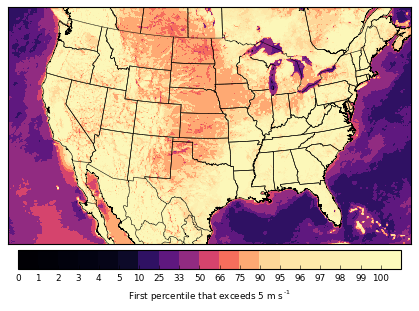

In [7]:
m.drawcoastlines(linewidth=.5); m.drawstates(linewidth=.5); m.drawcountries(linewidth=.5)
m.contourf(lon, lat, pdata, 
           levels=percentiles+[101],
           latlon=True,
           cmap='magma')
cb = plt.colorbar(orientation='horizontal', pad=0.01, shrink=.95, ticks=percentiles)
cb.set_label(r'First percentile that exceeds %s m s$\mathregular{^{-1}}$' % threshold)

#plt.title('%s' % (DATE.strftime('%B %H:%M UTC')), fontweight='semibold')

plt.savefig('./figs/Fig_10_CONUS_percentiles_thresh_m%02d_h%02d' % (DATE.month, DATE.hour))
print 'DATE: %s' % (DATE.strftime('%d %B %H:%M UTC'))

In [8]:
# Percentile Variable and Statistic of interest
var = 'UVGRD:10 m'
variable = var.replace(':', '_').replace(' ', '_')
DIR = '/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/%s/' % (variable)

# Specify Date: 
#  - Use a leapyear incase we request February 29th
#  - Use the 15th day of the month to capture the full month
leapyear = 2016
DATE = datetime(leapyear, 4, 13, 0)

# Requested File
FILE = DIR+'OSG_HRRR_%s_m%02d_d%02d_h%02d_f00.h5' % (variable, DATE.month, DATE.day, DATE.hour)

# Threshold value
threshold = 5

# List of available percentiles in the gridded dataset
percentiles = [0,1,2,3,4,5,10,25,33,50,66,75,90,95,96,97,98,99,100]

# Make sure the percentiles are sorted and they are in desending order...
percentiles.sort()
percentiles.reverse()

# Initiate an array of 100 for maximum percentile, becuase every point
# will require at least the maximum percentile to reach the threshold.
# We will replace grids with other percentiles if one is found to 
# hit the threshold at an earlier percentile.
pdata = np.ones_like(lon)*100

for i, P in enumerate(percentiles):
    print '\r>> %.2f%% complete. Working on p%s' % (float(i)/len(percentiles)*100, P),
    sys.stdout.flush()
    # Temporaritly store the percentile field
    ptemp = get_area(FILE, 'p%02d' % P)
    pdata[ptemp >= threshold] = P

# Need to sort percentiles back to ascending order for plotting later
percentiles.sort()

print '\r>> 100% complete'
sys.stdout.flush()

>> 100% complete


## Create the Figure

DATE: 13 April 00:00 UTC


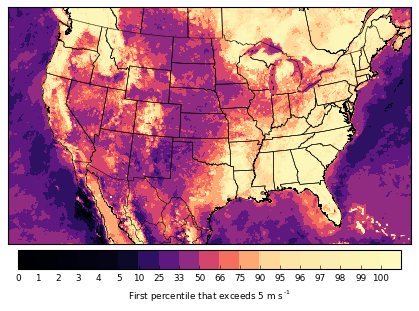

In [10]:
m.drawcoastlines(linewidth=.5); m.drawstates(linewidth=.5); m.drawcountries(linewidth=.5)
m.contourf(lon, lat, pdata, 
           levels=percentiles+[101],
           latlon=True,
           cmap='magma')
cb = plt.colorbar(orientation='horizontal', pad=0.01, shrink=.95, ticks=percentiles)
cb.set_label(r'First percentile that exceeds %s m s$\mathregular{^{-1}}$' % threshold)

#plt.title('%s' % (DATE.strftime('%B %H:%M UTC')), fontweight='semibold')

plt.savefig('./figs/Fig_10_CONUS_percentiles_thresh_m%02d_h%02d' % (DATE.month, DATE.hour))
print 'DATE: %s' % (DATE.strftime('%d %B %H:%M UTC'))